# M-$\sigma_{*}$ for subhalos at z = 0.62

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py

from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pqw

from functools import reduce
import operator
import gc

h = 0.6774
a = 1/(1+0.62)
box_size = 205000
t_h = 7.786*1e9

In [2]:
# plot settings
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import broadcast, col, sqrt, pow, floor, monotonically_increasing_id, abs, pmod, least, row_number
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://sohnic:7077") \
    .config("spark.executor.memory", "100g")\
    .config("spark.driver.memory", "100g") \
    .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir("hdfs://sohnic:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize", 524288000) # 500MB 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 15:00:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Reading the particle and subhalo data

In [4]:
%%time
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_sorted.parquet.snappy'
outname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/snap062_cubic_indexed.parquet.snappy'

rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(outname)

CPU times: user 8.57 ms, sys: 0 ns, total: 8.57 ms
Wall time: 3 s


In [5]:
rawdf.printSchema()

root
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- vx: float (nullable = true)
 |-- vy: float (nullable = true)
 |-- vz: float (nullable = true)
 |-- mass: float (nullable = true)
 |-- ix: integer (nullable = true)
 |-- iy: integer (nullable = true)
 |-- iz: integer (nullable = true)



In [6]:
%%time
rawdf.describe().show() 

+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|                px|                py|               pz|                vx|               vy|                vz|              mass|                ix|                iy|                iz|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|         563403122|         563403122|        563403122|         563403122|        563403122|         563403122|         563403122|         563403122|         563403122|         563403122|
|   mean|62063.620506918676| 61360.01957881405|65085.73962558534|0.6389386007963277| 0.93302996255295|0.7647258058670451| 8217982.296049925|1470.8627902810947|1454.1819635798895|1542.5085003859813|
| stddev| 

In [5]:
%%time
#subhalo table
#subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim.parquet.snappy'
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/subhalo62_trim.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

subdf.limit(4).toPandas()
#subdf.describe().toPandas().T 

CPU times: user 144 ms, sys: 4.8 ms, total: 149 ms
Wall time: 5.34 s


,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sfr,sub_id,sub_ix,sub_iy,sub_iz
0,106338.132812,122291.148438,100434.812500,193.304871,26.835810,-274.536133,1.168569e+09,0.244438,2203265,5041,5798,4762
1,112925.492188,1580.653564,37148.371094,-101.526550,-103.180550,24.824450,1.109962e+09,0.270853,2203267,5354,74,1761
2,117636.367188,84859.187500,39414.238281,-152.174469,150.268723,-18.883261,1.145129e+09,0.384633,2203272,5577,4023,1868
3,123173.906250,100851.187500,39630.644531,167.546005,120.392853,10.042540,1.800862e+09,0.415059,2203277,5840,4781,1879


# 2. Saving the particle data within the 50kpc spheres centered at each subhalo

In [6]:
id_size = 6000 #number of subboxes
subbox_size = box_size/id_size 

#nearby subbox id
subdf = subdf.withColumn("sub_ix_max", F.floor(F.pmod(F.col("sub_px") + 50*h, box_size) / (subbox_size)).cast('int')
            ).withColumn("sub_ix_min", F.floor(F.pmod(F.col("sub_px") - 50*h, box_size) / (subbox_size)).cast('int')
            ).withColumn("sub_iy_max", F.floor(F.pmod(F.col("sub_py") + 50*h, box_size) / (subbox_size)).cast('int')
            ).withColumn("sub_iy_min", F.floor(F.pmod(F.col("sub_py") - 50*h, box_size) / (subbox_size)).cast('int')
            ).withColumn("sub_iz_max", F.floor(F.pmod(F.col("sub_pz") + 50*h, box_size) / (subbox_size)).cast('int')
            ).withColumn("sub_iz_min", F.floor(F.pmod(F.col("sub_pz") - 50*h, box_size) / (subbox_size)).cast('int'))

#nearby_subboxes = subdf.select(
#    'sub_id', 'sub_px', 'sub_py', 'sub_pz', 'sub_vx', 'sub_vy', 'sub_vz', 'sub_mass',
#    F.array('sub_ix_min', 'sub_ix_max').alias('ix_values'),
#    F.array('sub_iy_min', 'sub_iy_max').alias('iy_values'),
#    F.array('sub_iz_min', 'sub_iz_max').alias('iz_values')
#)

nearby_subboxes = subdf.select(
    'sub_id', 'sub_px', 'sub_py', 'sub_pz', 'sub_vx', 'sub_vy', 'sub_vz', 'sub_ix', 'sub_iy', 'sub_iz'
)

nearby_subboxes = nearby_subboxes.filter(F.col("sub_mass")>1e10)
nearby_subboxes.limit(4).toPandas()

,sub_id,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_ix,sub_iy,sub_iz
0,1933026,52048.312500,80791.187500,109859.414062,118.627007,183.041565,288.900452,2467,3830,5208
1,1933038,62546.656250,119102.429688,97220.265625,29.280327,197.688629,-243.044174,2965,5647,4609
2,1933531,14708.768555,63638.988281,89564.570312,452.664825,-193.226410,-361.209015,697,3017,4246
3,1934262,112766.156250,35710.515625,107054.664062,-62.954769,484.494110,52.330307,5346,1693,5075


In [7]:
#saving the table
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/subhalo_nearby_subboxes_less_cube_241112.parquet.snappy'
nearby_subboxes.write.option("compression", "snappy").mode("overwrite").parquet(subname)

In [9]:
#reading the table
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/subhalo_nearby_subboxes_less_cube_241112.parquet.snappy'
nearby_subboxes = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)
nearby_subboxes.limit(4).toPandas()

,sub_id,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_ix,sub_iy,sub_iz
0,1231079,101529.679688,11010.246094,19232.332031,-19.296700,332.557648,201.952103,4813,522,911
1,1231080,101393.281250,11219.673828,19279.892578,-59.032967,109.307884,213.283936,4807,531,914
2,1231097,90167.437500,101699.703125,72458.671875,53.275944,-1.174462,171.603851,4275,4822,3435
3,1231129,44360.660156,104085.234375,86392.898438,43.484589,-171.837585,22.408825,2103,4935,4096


In [10]:
nearby_subboxes.describe().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|            sub_id|           sub_px|           sub_py|            sub_pz|            sub_vx|             sub_vy|            sub_vz|            sub_ix|            sub_iy|            sub_iz|
+-------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+
|  count|             87483|            87483|            87483|             87483|             87483|              87483|             87483|             87483|             87483|             87483|
|   mean|1042000.1388955568|62303.85706876641| 61789.6859235174|64781.637677904204|0.9014831843732543|0.46639196059126026|0.4518360844604032|2953.6145536847157| 2929.236411645691| 3071.096064378222|
| std

In [30]:
nearby_subboxes = nearby_subboxes.filter(F.col("sub_id") < 100)
nearby_subboxes.show(4)

+------+---------+---------+---------+----------+---------+----------+----------+----------+------------+
|sub_id|   sub_px|   sub_py|   sub_pz|    sub_vx|   sub_vy|    sub_vz| ix_values| iy_values|   iz_values|
+------+---------+---------+---------+----------+---------+----------+----------+----------+------------+
|     0|26036.086|28844.766|92127.484| 309.86075| 370.3195|-178.45361|[380, 381]|[421, 422]|[1347, 1348]|
|     1|26404.248|30159.396|91536.664| -636.0156|-537.5617|-327.95447|[385, 386]|[440, 441]|[1339, 1340]|
|     2|25343.588|28196.871|93531.875|  977.2291|171.58363|-1266.1193|[370, 371]|[412, 413]|[1368, 1369]|
|     3|25919.512|28735.574| 92183.22|-22.930883|203.08475| 171.58553|[378, 379]|[420, 421]|[1348, 1349]|
+------+---------+---------+---------+----------+---------+----------+----------+----------+------------+
only showing top 4 rows



In [33]:
radius_sq = (50*h)**2 #50kpc aperture size
id_size = 6000 #number of boxes
subbox_size = box_size/id_size
half_box = box_size/2

#broad casting the subhalo table to the all workers
broadcast_subdf = F.broadcast(nearby_subboxes)

# Step 2: Join rawdf and broadcast_subdf based on conditions on subbox id
filtered_df = (
    rawdf.alias("particles")
    .join(
        broadcast_subdf.alias("subboxes"),
        ( (F.least(F.abs(F.col("ix") - F.col("sub_ix")), id_size - F.abs(F.col("ix") - F.col("sub_ix"))) <= 1) &
    (F.least(F.abs(F.col("iy") - F.col("sub_iy")), id_size - F.abs(F.col("iy") - F.col("sub_iy"))) <= 1) &
    (F.least(F.abs(F.col("iz") - F.col("sub_iz")), id_size - F.abs(F.col("iz") - F.col("sub_iz"))) <= 1)
            )
        )
    .select(
        "subboxes.sub_id", "subboxes.sub_px", "subboxes.sub_py", "subboxes.sub_pz", "subboxes.sub_vx", "subboxes.sub_vy", "subboxes.sub_vz", "particles.*"
    )
)

#displacement vector component considering the periodic boundary
filtered_df = filtered_df.withColumn("rel_px", F.pmod(F.col("particles.px") - F.col("subboxes.sub_px") + half_box, box_size) - half_box
                        ).withColumn("rel_py", F.pmod(F.col("particles.py") - F.col("subboxes.sub_py") + half_box, box_size) - half_box
                        ).withColumn("rel_pz", F.pmod(F.col("particles.pz") - F.col("subboxes.sub_pz") + half_box, box_size) - half_box
                        )

# Step 4: Calculate dist_cent_sq
filtered_df = filtered_df.withColumn("dist_cent_sq", F.pow(F.col("rel_px"), 2) + F.pow(F.col("rel_py"), 2) + F.pow(F.col("rel_pz"), 2) )

# Step 5: Fine filter by distance squared
filtered_df = filtered_df.filter(F.col("dist_cent_sq") < radius_sq)

filtered_df = filtered_df.withColumn("rel_vx", F.col("particles.vx") - F.col("subboxes.sub_vx") 
                        ).withColumn("rel_vy", F.col("particles.vy") - F.col("subboxes.sub_vy") 
                        ).withColumn("rel_vz", F.col("particles.vz") - F.col("subboxes.sub_vz") 
                        )

result_df = filtered_df.select("sub_id", "rel_px", "rel_py", "rel_pz", "rel_vx", "rel_vy", "rel_vz", "mass", "dist_cent_sq")

subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/extracted_region_less_cube_z0p62_241112.parquet.snappy'
result_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

In [4]:
#Checking the data
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/extracted_region_less_cube_z0p62_241112.parquet.snappy'
df = spark.read.parquet(subname)

df.describe().show()
#df_filtered = df.filter(df.sub_id == 100)
#df_filtered.describe().toPandas()

24/11/15 09:21:39 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 524288000 bytes). This may impact query planning performance.


+-------+--------------------+--------------------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+
|summary|              rel_px|              rel_py|              rel_pz|            rel_vx|              rel_vy|            rel_vz|             mass|      dist_cent_sq|            sub_id|
+-------+--------------------+--------------------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+
|  count|           478817069|           478817069|           478817069|         478817069|           478817069|         478817069|        478817069|         478817069|         478817069|
|   mean|-0.01944070394258409|-7.90087093911818...|0.019826083175699134|0.3782331072614322|-0.27346111298744535|0.6598237233230838|8058542.538608838|119.48961546411627| 786447.9507375624|
| stddev|   6.301622666948237|   6.344505070730692|   6.2869

# 3. Calculating stellar velocity dispersion

We measure the stellar velocity dispersion of ~10$^5$ subhalos. We first select stellar particles within subhalo-centered spheres with a certain radius. We then calculate the mass-weighted stellar velocity dispersion based on the 3D velocity of selected stellar particles. 

### $M = \Sigma m_i $
### $\overline{v_x} = \frac{\Sigma m_i v_{i,x}}{M}$, $\, \overline{v_y} = \frac{\Sigma m_i v_{i,y}}{M}$, $\, \overline{v_z} = \frac{\Sigma m_i v_{i,z}}{M}$ 
### $\sigma_x^2 = \frac{\Sigma m_i (v_{i,x} - \overline{v_{x}})^2}{M}$, $\, \sigma_y^2 = \frac{\Sigma m_i (v_{i,y} - \overline{v_{y}})^2}{M}$, $\, \sigma_z^2 = \frac{\Sigma m_i (v_{i,z} - \overline{v_{z}})^2}{M}$
### $\therefore \sigma_{3D} = \sqrt{\sigma_x^2 + \sigma_y^2 + \sigma_z^2}$
### if $\sigma_{1D} = \sigma_{x} = \sigma_{y} = \sigma_{z}$
### $ \sigma_{3D} = \sqrt{3} \sigma_{1D} \rightarrow \sigma_{1D} =\frac{1}{\sqrt{3}} \sigma_{3D}$
We repeat the above calculation for six different radii (3, 5, 10, 20, 30, and 50 kpc).

In [4]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/extracted_region_less_cube_z0p62_241112.parquet.snappy'

df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

24/12/06 15:12:56 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 524288000 bytes). This may impact query planning performance.


,summary,rel_px,rel_py,rel_pz,rel_vx,rel_vy,rel_vz,mass,dist_cent_sq,sub_id
0,count,151447,151447,151447,151447,151447,151447,151447,151447,151447
1,mean,0.1704504737011958,-0.1528960007461356,0.2635008039115994,440.6934147059059,560.3827684119564,-33.87995422353609,7633500.072618639,183.7033798820631,0.0
2,stddev,8.27653850386334,7.901100477306011,7.25632486112689,444.12699017457595,433.8891285079006,393.4529891368258,2035246.6803190988,280.0248772714296,0.0
3,min,-31.44921875,-33.302734375,-25.109375,-2777.678,-2450.4937,-2868.4385,637647.25,0.0,0
4,max,31.775390625,28.171875,33.6171875,2719.042,3246.275,2515.3655,1.4766947E7,1147.1328887939453,0


In [5]:
subhalo_count = df.select("sub_id").distinct().count()
print(f"Number of distinct subhalo IDs: {subhalo_count}")

Number of distinct subhalo IDs: 87483


In [6]:
%%time
from pyspark.sql import Window as W
import pyspark.sql.functions as F

# Define subhalo window for partitioning by "sub_id"
subhalo_window = W.partitionBy("sub_id")

# Initial weighted velocity and dispersion calculations for all particles
df = df.withColumn("vx_weighted", F.col("mass") * F.col("rel_vx"))
df = df.withColumn("vy_weighted", F.col("mass") * F.col("rel_vy"))
df = df.withColumn("vz_weighted", F.col("mass") * F.col("rel_vz"))

df = df.withColumn("mass_sum", F.sum("mass").over(subhalo_window))

df = df.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))

df = df.withColumn("vx_disp", (F.col("rel_vx") - F.col("vx_avg"))**2)
df = df.withColumn("vy_disp", (F.col("rel_vy") - F.col("vy_avg"))**2)
df = df.withColumn("vz_disp", (F.col("rel_vz") - F.col("vz_avg"))**2)

df = df.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

# First aperture (50 kpc)
velocity_dispersion_df = df.groupBy("sub_id").agg(
    (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_50")
)

df = df.withColumn(
    "j_x",
    F.col("mass") * ( F.col("rel_py") * F.col("rel_vz") - F.col("rel_pz") * F.col("rel_vy") )
).withColumn(
    "j_y",
    F.col("mass") * ( F.col("rel_pz") * F.col("rel_vx") - F.col("rel_px") * F.col("rel_vz") )
).withColumn(
    "j_z",
    F.col("mass") * ( F.col("rel_px") * F.col("rel_vy") - F.col("rel_py") * F.col("rel_vx") )
)

df = df.withColumn("j_tot_x", F.sum("j_x").over(subhalo_window) 
                        ).withColumn("j_tot_y", F.sum("j_y").over(subhalo_window) 
                        ).withColumn("j_tot_z", F.sum("j_z").over(subhalo_window) 
                        )

df = df.withColumn("j_tot", F.sqrt(F.col("j_tot_x")*F.col("j_tot_x") + F.col("j_tot_y")*F.col("j_tot_y") + F.col("j_tot_z")*F.col("j_tot_z"))  )

#rotational axis // angular momentum direction, rotational axis component
df = df.withColumn("j_rot", (F.col("j_x")*F.col("j_tot_x") + F.col("j_y")*F.col("j_tot_y") + F.col("j_z")*F.col("j_tot_z")) / F.col("j_tot") )
#position vector projected on the rotational axis
df = df.withColumn("R_tot", (F.col("rel_px")*F.col("j_tot_x") + F.col("rel_py")*F.col("j_tot_y") + F.col("rel_pz")*F.col("j_tot_z")) / F.col("j_tot") )
df = df.withColumn("R_rot", F.sqrt( F.col("dist_cent_sq") - F.col("R_tot")*F.col("R_tot") ) )
df = df.filter(F.col("R_rot") != 0)
df = df.withColumn("mV_rot", F.col("j_rot")/F.col("R_rot"))

velocity_rotation_tmp = df.groupBy("sub_id").agg(
    (F.sum("mV_rot") / F.max("mass_sum")).alias("mass_weighted_velocity_rotation_50")
)
velocity_dispersion_df = velocity_dispersion_df.join(velocity_rotation_tmp, "sub_id")

# Iterate through different apertures (30, 20, 10, 5, 3 kpc)
for apert in [30, 20, 10, 5, 3]:
    # Reset the DataFrame for each aperture
    distance_limit = (apert * h) ** 2
    df_aperture = df.filter(F.col("dist_cent_sq") <= distance_limit)

    df_aperture = df_aperture.withColumn("mass_sum", F.sum("mass").over(subhalo_window))
    
    df_aperture = df_aperture.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))
    
    df_aperture = df_aperture.withColumn("vx_disp", (F.col("rel_vx") - F.col("vx_avg"))**2)
    df_aperture = df_aperture.withColumn("vy_disp", (F.col("rel_vy") - F.col("vy_avg"))**2)
    df_aperture = df_aperture.withColumn("vz_disp", (F.col("rel_vz") - F.col("vz_avg"))**2)
    
    df_aperture = df_aperture.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

    df_aperture = df_aperture.withColumn("j_tot_x", F.sum("j_x").over(subhalo_window) 
                            ).withColumn("j_tot_y", F.sum("j_y").over(subhalo_window) 
                            ).withColumn("j_tot_z", F.sum("j_z").over(subhalo_window) 
                            )
    
    df_aperture = df_aperture.withColumn("j_tot", F.sqrt(F.col("j_tot_x")*F.col("j_tot_x") + F.col("j_tot_y")*F.col("j_tot_y") + F.col("j_tot_z")*F.col("j_tot_z"))  )
    
    #rotational axis // angular momentum direction, rotational axis component
    df_aperture = df_aperture.withColumn("j_rot", (F.col("j_x")*F.col("j_tot_x") + F.col("j_y")*F.col("j_tot_y") + F.col("j_z")*F.col("j_tot_z")) / F.col("j_tot") )

    #position vector projected on the rotational axis
    df_aperture = df_aperture.withColumn("R_tot", (F.col("rel_px")*F.col("j_tot_x") + F.col("rel_py")*F.col("j_tot_y") + F.col("rel_pz")*F.col("j_tot_z")) / F.col("j_tot") )
    df_aperture = df_aperture.withColumn("R_rot", F.sqrt( F.col("dist_cent_sq") - F.col("R_tot")*F.col("R_tot") ) )
    #df_aperture = df_aperture.withColumn("R_rot", F.sqrt( F.pow(F.col("rel_px"), 2) + F.pow(F.col("rel_py"), 2) + F.pow(F.col("rel_pz"), 2) - F.col("R_tot")*F.col("R_tot") ) )
    #df_aperture = df_aperture.withColumn("R_rot", F.when(F.col("R_rot") == 0, F.lit(1e-10)).otherwise(F.col("R_rot"))) #dealing with zero value to prevent nan value

    df_aperture = df_aperture.withColumn("mV_rot", F.col("j_rot")/F.col("R_rot"))
    
    velocity_dispersion_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass")/3)).alias("mass_weighted_velocity_dispersion_" + str(apert))
    )

    df_aperture = df_aperture.filter(F.col("R_rot") != 0)
    velocity_rotation_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sum("mV_rot") / F.max("mass_sum")).alias("mass_weighted_velocity_rotation_" + str(apert))
    )
    
    # Combine the results for each aperture
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_dispersion_tmp, "sub_id")
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_rotation_tmp, "sub_id")

# Show the final combined DataFrame
velocity_dispersion_df.show()

24/12/06 15:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB


+------+------------------------------------+----------------------------------+------------------------------------+----------------------------------+------------------------------------+----------------------------------+------------------------------------+----------------------------------+-----------------------------------+---------------------------------+-----------------------------------+---------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_rotation_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_rotation_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_rotation_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_rotation_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_rotation_5|mass_weighted_velocity_dispersion_3|mass_weighted_velocity_rotation_3|
+------+------------------------------------+----------------------------------+------------------------------------+---------

In [ ]:
%%time
#    filtered_df.write.mode("overwrite").parquet(subname, compression="snappy")

parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/vdisp_241115.parquet'
velocity_dispersion_df.write.option("compression", "snappy").mode("overwrite").parquet(parquet_files_path)

24/12/06 15:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1478.1 KiB


# 4. One to one Comparison with the table value
Table values are based on the stellar particles with the subhalo membership.
However, Hadoop calculated the velocity dispersion based on all stellar particles in the spheres. There is a slight difference in their values.

In [4]:
#parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_241015/vdisp_241015_*.parquet'
#
## Read all matching files with the glob pattern
#combined_df = spark.read.parquet(parquet_files_path)
#combined_df = combined_df.dropDuplicates(['sub_id'])
#
## Show the schema and some data
#combined_df.printSchema()
#combined_df.describe().toPandas().T 

parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/vdisp_241115.parquet'
df = spark.read.parquet(parquet_files_path)

df.printSchema()
df.describe().toPandas().T 

root
 |-- sub_id: integer (nullable = true)
 |-- mass_weighted_velocity_dispersion_50: double (nullable = true)
 |-- mass_weighted_velocity_rotation_50: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_30: double (nullable = true)
 |-- mass_weighted_velocity_rotation_30: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_10: double (nullable = true)
 |-- mass_weighted_velocity_rotation_10: double (nullable = true)



,0,1,2,3,4
summary,count,mean,stddev,min,max
sub_id,87483,1042000.1388955568,484673.50998555287,0,2355669
mass_weighted_velocity_dispersion_50,87483,190.9985480488664,77.6887818907298,72.79046279867683,1665.432746654881
mass_weighted_velocity_rotation_50,87483,70.31796902638746,50.91865526177697,-87.00865986348177,1775.3405848622456
mass_weighted_velocity_dispersion_30,87483,184.8952349525684,65.23461418869618,67.28245223022317,1439.6568014903223
mass_weighted_velocity_rotation_30,87483,68.74822288661213,41.778869383639375,-56.27788893391559,1644.3834453649308
mass_weighted_velocity_dispersion_10,87483,175.62001326200235,50.69785600871365,65.27493635575266,942.8145130051805
mass_weighted_velocity_rotation_10,87483,63.69872742937452,34.42023014640439,-33.11116092776246,999.8173386194593


In [5]:
#subhalo table (~few seconds)
subname = 'hdfs://sohnic:54310/data/TNG300/snap62/parquet/subhalo62_trim.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

subdf.limit(4).toPandas()

t300_jungwon = pd.read_csv('./TNG300/snap62/HR5_sigma.csv')
print(len(t300_jungwon))
t300_jungwon.head()

54213


,fofid,subid,mstar,mdm,HRsigmaz10,HRsigmaztot,ratio,SFR_100Myr,"R1/2 (M*,2D)"
0,70339,70461,1.001380e+10,2.821158e+11,93.316437,94.892383,1.427929,1.069794,3.471264
1,127701,128004,1.158886e+10,3.417171e+11,96.785964,92.702967,0.854357,2.037702,3.936234
2,127946,128254,1.104230e+10,3.407741e+11,81.106481,83.362555,1.063367,2.827312,5.193584
3,128066,128374,1.023547e+10,2.462796e+11,74.781034,81.823698,1.670653,0.356598,6.025010
4,128611,128922,1.138650e+10,5.114676e+11,97.712611,85.944056,1.084436,0.738667,6.854766


In [6]:
# sorting the pyspark dataframe based on sub_id & caching the data
#sorted_combined_df = combined_df.orderBy('sub_id')
sorted_combined_df = df.orderBy('sub_id')
sorted_combined_df.cache()

df_spark = pd.DataFrame()
df_spark['sig_10'] = sorted_combined_df.select('mass_weighted_velocity_dispersion_10').toPandas()
df_spark['sig_30'] = sorted_combined_df.select('mass_weighted_velocity_dispersion_30').toPandas()
df_spark['rot_30'] = sorted_combined_df.select('mass_weighted_velocity_rotation_30').toPandas()

df_spark['sub_id'] = sorted_combined_df.select('sub_id').toPandas()

In [7]:
sorted_combined_df = subdf.orderBy('sub_id')
sorted_combined_df.cache()

df_csv = pd.DataFrame()
df_csv['sub_mass'] = sorted_combined_df.select('sub_mass').toPandas()
df_csv['sub_id'] = sorted_combined_df.select('sub_id').toPandas()
df_csv['sfr'] = sorted_combined_df.select('sfr').toPandas()

df_jungwon = pd.DataFrame()
df_jungwon['sig_jungwon'] = t300_jungwon['HRsigmaz10']
df_jungwon['sub_mass_jungwon'] = t300_jungwon['mstar']
df_jungwon['sig/rot'] = t300_jungwon['ratio']
df_jungwon['sfr'] = t300_jungwon['SFR_100Myr']

df_jungwon.head(10)

,sig_jungwon,sub_mass_jungwon,sig/rot,sfr
0,93.316437,1.001380e+10,1.427929,1.069794
1,96.785964,1.158886e+10,0.854357,2.037702
2,81.106481,1.104230e+10,1.063367,2.827312
3,74.781034,1.023547e+10,1.670653,0.356598
4,97.712611,1.138650e+10,1.084436,0.738667
5,95.418044,1.222419e+10,1.532128,1.604690
6,96.935693,1.140899e+10,1.348852,1.706576
7,89.163120,1.069018e+10,1.442423,1.477334
8,97.558999,1.399266e+10,1.111237,2.241472
9,101.785113,1.434880e+10,0.862438,5.527267


In [8]:
result_df = pd.merge(df_spark, df_csv, on="sub_id", how="inner", suffixes=('_spark', '_csv'))
result_df.tail(10)

,sig_10,sig_30,rot_30,sub_id,sub_mass,sfr
87473,128.694223,128.144364,56.893182,2227210,1.354687e+10,0.000000
87474,115.647502,115.392003,38.087047,2228630,1.138023e+10,0.000000
87475,126.696927,125.037165,51.477253,2243237,1.326121e+10,0.000000
87476,127.465834,123.387378,54.739995,2265718,1.256207e+10,0.000000
87477,134.032718,131.758286,62.965431,2281171,1.563966e+10,0.000000
87478,122.125793,122.250227,64.132889,2284511,1.128668e+10,0.000000
87479,123.928834,122.106667,45.356446,2307761,1.016667e+10,0.000000
87480,120.482823,117.751015,38.183924,2322341,1.221549e+10,0.000000
87481,127.053126,124.182485,55.671046,2339031,1.285786e+10,0.305802
87482,111.182989,109.154781,42.137879,2355669,1.004176e+10,0.000000


In [9]:
#Quiscent galaxy selection based on velocity ratio and sSFR.
print((len(result_df[result_df['rot_30'] / (result_df['sig_30'])<0.5]))/len(result_df['sig_30']))
print(len(result_df[result_df['sfr']/result_df['sub_mass']<0.2/t_h])/len(result_df['sfr']))

#comparison with HR5 results
print(len(df_jungwon[df_jungwon['sig/rot']*np.sqrt(3)<0.5])/len(df_jungwon['sig/rot']))
print(len(df_jungwon[df_jungwon['sfr']/df_jungwon['sub_mass_jungwon']<0.2/t_h])/len(df_jungwon['sig/rot']))
print(len(df_jungwon[df_jungwon['sfr']/df_jungwon['sub_mass_jungwon']<0.2/t_h]))

0.3124264142747734
0.3186904884377536
0.05854684300813458
0.07166177854020253
3885


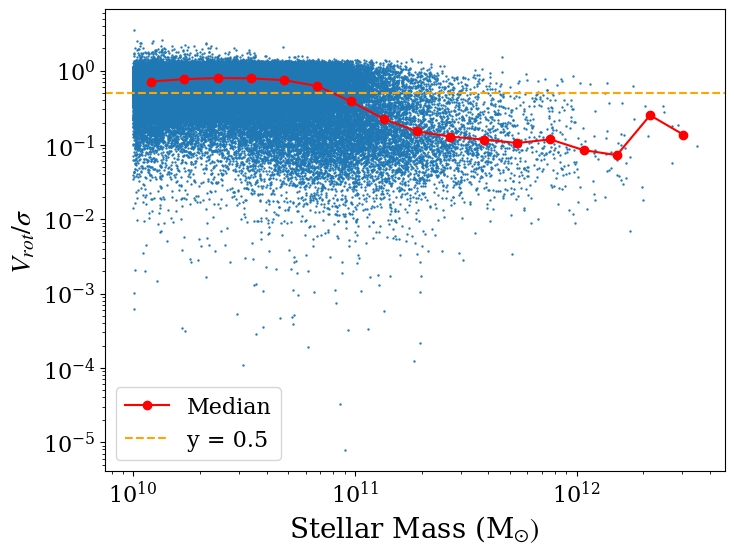

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your DataFrame
x = result_df['sub_mass']
y = result_df['rot_30']/ result_df['sig_30']

# Define logarithmic bins
bins = np.logspace(np.log10(1e10), np.log10(1e13), 21)  # 20 bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate bin centers for plotting

# Digitize x values into bins
bin_indices = np.digitize(x, bins)

# Calculate the median of y in each bin
median_y = [np.median(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(1, len(bins))]

# Plot the scatter and median line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=0.5)
plt.plot(bin_centers, median_y, color='red', marker='o', label='Median')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Stellar Mass (M$_{\odot})$', fontsize = 20)
plt.ylabel(r'$V_{rot}/\sigma$', fontsize = 20)
plt.axhline(y = 0.5, color = 'orange', ls = '--', label = 'y = 0.5')
plt.legend()
plt.show()

Text(0.5, 0, 'sSFR (yr$^{-1}$)')

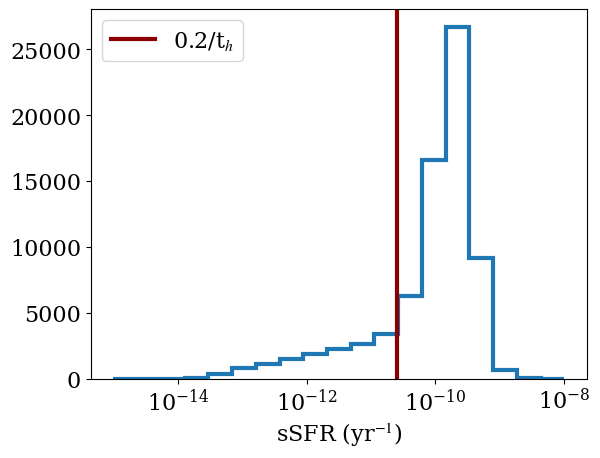

In [13]:
#result_df[result_df['sfr']/result_df['sub_mass']<0.2/t_h]
bins = np.logspace(-15,-8, 20)
plt.hist(result_df['sfr']/result_df['sub_mass'],bins = bins, histtype = 'step', lw = 3)
plt.axvline(x = 0.2/t_h, lw = 3, color = 'darkred', label = r'0.2/t$_{h}$')
plt.xscale('log')
plt.legend()
plt.xlabel(r'sSFR (yr$^{-1}$)')

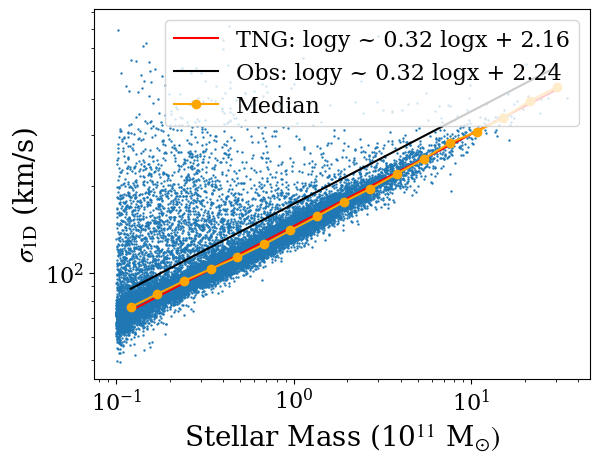

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming result_df['sub_mass'] and result_df['sig'] contain the data
#x = result_df['sub_mass']/1e11
#y = result_df['sig_10']/np.sqrt(3)
x = result_df['sub_mass'][result_df['rot_30'] / (result_df['sig_30']/np.sqrt(3))<0.5]/1e11
y = result_df['sig_30'][result_df['rot_30'] / (result_df['sig_30']/np.sqrt(3))<0.5] #sigma 1D
#x = result_df['sub_mass'][result_df['sfr']/result_df['sub_mass']<0.2/t_h]/1e11
#y = result_df['sig_10'][result_df['sfr']/result_df['sub_mass']<0.2/t_h]

# Define logarithmic bins
bins = np.logspace(np.log10(1e10), np.log10(1e13), 21) /1e11 # 20 bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate bin centers for plotting

# Digitize x values into bins
bin_indices = np.digitize(x, bins)

# Calculate the median of y in each bin
median_y = [np.median(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(1, len(bins))]

# Log-transform the data
#log_x = np.log10(x)
#log_y = np.log10(y)
log_x = np.log10(bin_centers[:-3]) 
log_y = np.log10(median_y[:-3]) #to avoid nan values

# Perform linear regression in log space
slope, intercept, _, _, _ = linregress(log_x, log_y)

# Generate points for the linear fit line
fit_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_y = slope * fit_x + intercept
fit_y_obs = 0.32 * fit_x + 2.24 #from Zahid+16 SHELS survey 

# Plot the data and the fit line in log-log space
plt.scatter(x, y, s=0.5)
plt.plot(10**fit_x, 10**fit_y, color='red', label=f'TNG: logy ~ {slope:.2f} logx + {intercept:.2f}')
plt.plot(10**fit_x, 10**fit_y_obs, color='k', label=f'Obs: logy ~ {0.32} logx + {2.24}')

plt.plot(bin_centers, median_y, color='orange', marker='o', label='Median')

# Set log scales
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Stellar Mass (10$^{11}$ M$_{\odot})$', fontsize = 20)
plt.ylabel(r'$\sigma_{\rm{1D}}$ (km/s)', fontsize = 20)
plt.legend()
plt.show()
